<a href="https://colab.research.google.com/github/floriandendorfer/demand-estimation/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. PACKAGES

In [101]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import IV2SLS
import matplotlib.pyplot as plt
from scipy import optimize
import seaborn as sns



---



## 2. DATA

In [103]:
#!rm -rf demand-estimation
!git clone https://github.com/floriandendorfer/demand-estimation.git
data = pd.read_csv('demand-estimation/data1.csv',index_col=0)

Cloning into 'demand-estimation'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 115 (delta 39), reused 44 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (115/115), 165.09 KiB | 4.86 MiB/s, done.
Resolving deltas: 100% (39/39), done.




---



## 3. FIRST LOOK AT THE DATA

### 3.1 VARIABLES

In [104]:
print(data.columns)

Index(['county', 'Häagen-Dazs', 'price', 'fuel cost', 'sales', 'county size'], dtype='object')


Each row contains sales information for an ice cream brand (i.e., Häagen-Dazs, Ben \& Jerry's) and a geographic market (i.e., a county).

*   `county` is the market identifier ($t$ in the slides).
*   `Häagen-Dazs` is 1 if the ice cream brand is Häagen-Dazs and 0 if the ice cream brand is Ben \& Jerry's.
*   `price` is the dollar price an ice cream serving of that brand is sold at.
*   `fuel cost` is the dollar cost of transporting an ice cream serving.
*   `sales` is the number of ice cream servings of that brand sold per week.
*   `county size` is the number of *total* ice cream servings sold per week.


### 3.2 DATA DESCRIPTION

Let's have a brief look at the data.

In [105]:
print(data.head(20))

    county  Häagen-Dazs     price  fuel cost  sales  county size
0        1            0  2.549066   0.432124     35          219
1        1            1  2.070158   0.265596     14          219
2        2            0  2.342645   0.255663     15          113
3        2            1  2.255875   0.441644      5          113
4        3            0  2.933863   0.634391     17          182
5        3            1  2.417164   0.435701     11          182
6        4            0  3.014971   0.928417      7          124
7        4            1  2.438474   0.481903     11          124
8        5            0  3.034538   0.433755     14          240
9        5            1  2.538901   0.525668     17          240
10       6            0  3.046907   0.999508      6          102
11       6            1  2.157727   0.130153     11          102
12       7            0  2.537953   0.676806     16          176
13       7            1  2.097775   0.240460      4          176
14       8            0  

Pick your favorite county.

In [106]:
t = 10

In [107]:
print('In total,',data['county size'][t],'ice cream servings are sold in county',data['county'][t],'. As',data['sales'][t],' of them were ',np.where(data['Häagen-Dazs'][t] == 0, "Ben & Jerry's","Häagen-Dazs")," ice cream, that brand's market share in this county is ",(100*data['sales'][t]/data['county size'][t]).round(2),'%. The price of a serving of', np.where(data['Häagen-Dazs'][t] == 0, "Ben & Jerry's","Häagen-Dazs"),'ice cream in this county is $',data['price'][t].round(2),'.')

In total, 102 ice cream servings are sold in county 6 . As 6  of them were  Ben & Jerry's  ice cream, that brand's market share in this county is  5.88 %. The price of a serving of Ben & Jerry's ice cream in this county is $ 3.05 .


In [108]:
data.describe()

,county,Häagen-Dazs,price,fuel cost,sales,county size
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,100.500000,0.500000,2.476886,0.449150,15.897500,200.150000
std,57.806609,0.500626,0.380067,0.237135,10.318827,59.676299
min,1.000000,0.000000,1.566390,-0.206198,1.000000,100.000000
25%,50.750000,0.000000,2.175106,0.276338,8.000000,152.750000
50%,100.500000,0.500000,2.470965,0.445653,14.000000,195.500000
75%,150.250000,1.000000,2.775499,0.618561,21.000000,254.250000
max,200.000000,1.000000,3.374167,1.123239,58.000000,300.000000



1.   How many counties are there?
2.   What is the average price per serving?
2.   What is the average market size in the sample? What is the largest market size?
3.   What is the median number of ice cream servings sold per county?





## 4. MARKET SHARES

### 4.1 COMPUTING MARKET SHARES

In [109]:
data['s'] = data['sales']/data['county size']

Calculate the market share of each firm (Häagen-Dazs, Ben & Jerry's) in each county based on the number of ice cream units sold.


### 4.2 COMPARING MARKET SHARES AND PRICES

In [110]:
data.groupby('Häagen-Dazs')[['price','s']].describe().loc[:, (slice(None), ['count', 'mean', 'std'])]

price                          s                    
             count      mean       std  count      mean       std
Häagen-Dazs                                                      
0            200.0  2.769022  0.245062  200.0  0.103156  0.041946
1            200.0  2.184750  0.240890  200.0  0.053775  0.026664

Compare Häagen-Dazs and Ben & Jerry's in terms of their market shares and prices across counties.

1.   In how many counties is Häagen-Dazs ice cream sold? Ben \& Jerry's?
2.   Which ice cream brand is more expensive? Which one has the larger market share?
3.   Which ice cream brand do you think consumers prefer?
4.   For a given brand, do market shares vary across counties? If so, why do you think that is?


---



### 4.3 EVALUATING MARKET CONCENTRATION

Häagen-Dazs and Ben \& Jerry's are the only products in the market for 'super-premium' ice cream. Let's calculate the Hirschmann-Hifendahl Index (HHI) for county $t$:
$$10000\times\sum_{j\in\{H,B\}}s_{jt}^2$$


In [111]:
hhi1 = 10000*data.groupby('county')['s'].apply(lambda x: ((x/x.sum())**2).sum())

In [112]:
print('The average county-level HHI is',hhi1.mean().astype(int),'.')

The average county-level HHI is 5913 .


We could also report the HHI across counties:
$$ 10000\times \frac{\sum_{j\in\{H,B\}}(\sum_t \text{sales}_{jt})^2}{(\sum_{j\in\{H,B\}}\sum_t \text{sales}_{jt})^2} $$

In [113]:
hhi2 = 10000*(data[data['Häagen-Dazs'] == 1]['sales'].sum()**2 + data[data['Häagen-Dazs'] == 0]['sales'].sum()**2)/(data[data['Häagen-Dazs'] == 1]['sales'].sum() + data[data['Häagen-Dazs'] == 0]['sales'].sum())**2


In [114]:
print('The average HHI across counties is',hhi2.mean().astype(int),'.')

The average HHI across counties is 5488 .


Is the market for 'super-premium' ice cream highly concentrated, moderately concentrated or unconcentrated?

### 4.4 COMPUTING THE 'OUTSIDE OPTION' MARKET SHARE

In [115]:
data['s0'] = 1 - data.groupby(['county'])['s'].transform('sum')

Define the 'outside option' market share for each county. Here the 'outside good' is any ice cream sold other than Ben & Jerry's or Hägen-Dazs.

## 5. DEMAND ESTIMATION

### 5.1 TRANSFORMING THE DATA

Transform the market shares to back out the **mean utilities**. The transformed market share is going to be the **dependent variable** in the regressions we run. Remember:
$$ \ln(s_{jt}) - \ln(s_{0t}) = \alpha p_{jt} + \mathbf{x}_{jt}\boldsymbol{ \beta } + \xi_{jt} $$

In [116]:
Y = np.log(data['s']) - np.log(data['s0'])

In the regression, the **independent variables** are going to be the price and the Häagen-Dazs dummy variable, plus a constant.
$$ V_{jt} = \beta_0 + \beta_\text{Häagen-Dazs}\mathbf{1}(j = \text{Häagen-Dazs}) + \alpha p_{jt} + \xi_{jt} $$

In [117]:
X=sm.add_constant(data[['price','Häagen-Dazs']])

### 5.2 OLS REGRESSION

In [118]:
ols = sm.OLS(Y,X)
ols_result = ols.fit(cov_type='HC3')
ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     81.94
Date:                Thu, 19 Sep 2024   Prob (F-statistic):           1.62e-30
Time:                        15:25:44   Log-Likelihood:                -332.07
No. Observations:                 400   AIC:                             670.1
Df Residuals:                     397   BIC:                             682.1
Df Model:                           2                                         
Covariance Type:                  HC3                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.5005      0.305     -4.918      0.000      -2.099      -0.902
price          -0.2508      0.110     -2.278      0.023      -0.467      -0.035
Häagen-Dazs    -0.8418      0.083    -10.187      0.000      -1.004      -0.680
==============================================================================
Omnibus:                       72.286   Durbin-Watson:                   1.902
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              154.644
Skew:                          -0.947   Prob(JB):                     2.63e-34
Kurtosis:                       5.385   Cond. No.                         34.1
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

Let's interpret the estimation results.

1.   All else equal, how much lower is the mean utility of consuming a unit of ice cream if the unit price increases by \$1?
2.   On average, which ice cream brand do consumers prefer?
3.   What is the meaning of the constant? It is negative. Why do you think that is?
4. What is the mean utility of consuming a unit of Ben & Jerry's ice cream if it is sold for \$3?

### 5.3 ENDOGENEITY AND INSTRUMENTAL VARIABLE

Our estimate of the price coefficient is likely biased. The true coefficients are

\begin{align*}
  \beta_0 = & -0.44 \\
  \beta_{Häagen-Dazs} = & -1.07 \\
  \alpha = & -0.63
\end{align*}

Why is that? Do you think the fuel price is a good **instrumental variable** for the unit price?

In [119]:
first_stage = sm.OLS(data['price'],sm.add_constant(data[['fuel cost','Häagen-Dazs']]))
first_stage_result = first_stage.fit(cov_type='HC3')
first_stage_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     1192.
Date:                Thu, 19 Sep 2024   Prob (F-statistic):          1.48e-168
Time:                        15:25:57   Log-Likelihood:                 211.84
No. Observations:                 400   AIC:                            -417.7
Df Residuals:                     397   BIC:                            -405.7
Df Model:                           2                                         
Covariance Type:                  HC3                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.1603      0.024     88.575      0.000       2.112       2.208
fuel cost       1.0312      0.037     27.850      0.000       0.959       1.104
Häagen-Dazs    -0.2931      0.018    -16.675      0.000      -0.328      -0.259
==============================================================================
Omnibus:                        0.757   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.685   Jarque-Bera (JB):                0.614
Skew:                           0.090   Prob(JB):                        0.736
Kurtosis:                       3.068   Cond. No.                         7.78
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

1. Are the estimates significantly different from zero in a statistical sense?
2. According to our estimates, by how much does the unit price increase if the fuel cost increases by \$1 (and everything else is unchanged)? Does this intuitively make sense?

We plot Häagen-Dazs market shares and unit prices and fit a line (left). We compare this to the results of a 2SLS regression with fuel price as the instrument (right).

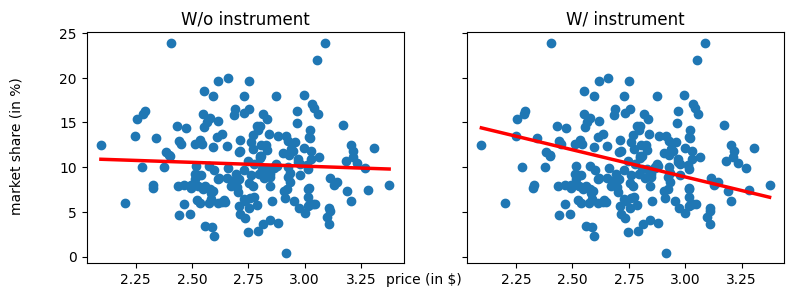

In [120]:
figure, axis = plt.subplots(1, 2,sharex=True,sharey=True,figsize=(9,3))

axis[0].scatter(data[data['Häagen-Dazs'] == 0]['price'],data[data['Häagen-Dazs'] == 0]['s']*100)
b, a = np.polyfit(data[data['Häagen-Dazs'] == 0]['price'], data[data['Häagen-Dazs'] == 0]['s']*100, deg=1)
axis[0].plot(np.linspace(data[data['Häagen-Dazs'] == 0]['price'].min(), data[data['Häagen-Dazs'] == 0]['price'].max(), num=80), a + b * np.linspace(data[data['Häagen-Dazs'] == 0]['price'].min(), data[data['Häagen-Dazs'] == 0]['price'].max(), num=80), color="red", lw=2.5)
axis[0].set_title('W/o instrument')

axis[1].scatter(data[data['Häagen-Dazs'] == 0]['price'],data[data['Häagen-Dazs'] == 0]['s']*100)
a,b = IV2SLS(data[data['Häagen-Dazs'] == 0]['s']*100, sm.add_constant(data[data['Häagen-Dazs'] == 0]['price']), instrument = sm.add_constant(data[data['Häagen-Dazs'] == 0]['fuel cost'])).fit().params
axis[1].plot(np.linspace(data[data['Häagen-Dazs'] == 0]['price'].min(), data[data['Häagen-Dazs'] == 0]['price'].max(), num=80), a + b * np.linspace(data[data['Häagen-Dazs'] == 0]['price'].min(), data[data['Häagen-Dazs'] == 0]['price'].max(), num=80), color="red", lw=2.5)
axis[1].set_title('W/ instrument')

figure.text(0.5, 0.04, 'price (in $)', ha='center')
figure.text(0.04, 0.5, 'market share (in %)', va='center', rotation='vertical')
plt.show()

Can you explain why the line on the right is steeper?

### 5.4 2SLS REGRESSION

Next, we re-estimate demand using the fuel cost to instrument the price of ice cream.

In [122]:
twosls = IV2SLS(np.log(data['s']) - np.log(data['s0']), sm.add_constant(data[['price','Häagen-Dazs']]), instrument = sm.add_constant(data[['fuel cost','Häagen-Dazs']]))
twosls_result = twosls.fit()
const, alpha, beta = twosls_result.params.round(2)
twosls_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          IV2SLS Regression Results                           
==============================================================================
Dep. Variable:                      y   R-squared:                       0.271
Model:                         IV2SLS   Adj. R-squared:                  0.267
Method:                     Two Stage   F-statistic:                     84.88
                        Least Squares   Prob (F-statistic):           2.04e-31
Date:                Thu, 19 Sep 2024                                         
Time:                        15:27:12                                         
No. Observations:                 400                                         
Df Residuals:                     397                                         
Df Model:                           2                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.5242      0.400     -1.310      0.191      -1.311       0.262
price          -0.6034      0.144     -4.198      0.000      -0.886      -0.321
Häagen-Dazs    -1.0478      0.101    -10.360      0.000      -1.247      -0.849
==============================================================================
Omnibus:                       65.151   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              124.790
Skew:                          -0.904   Prob(JB):                     7.98e-28
Kurtosis:                       5.055   Cond. No.                         34.1
==============================================================================
"""

Compare the OLS and 2SLS price coefficients. Which one has a larger magnitude?

## 6. BACKING OUT $c$ AND $\xi$

### 6.1 MARGINAL COSTS

Based on our estimates, we can back out the marginal costs of Häagen-Dazs' and Ben \& Jerry's using the FOCs of their profit maximization problems. Recall:
$$ \frac{\partial \pi_{jt}(p_{jt}^*)}{\partial p_{jt}} = \alpha s_{jt}(1-s_{jt})(p_{jt}^* - c_{jt}) + s_{jt} = 0 $$
$$ \widehat c_{jt} = p_{jt}^* + \frac{1}{\widehat \alpha(1-s_{jt})} $$

In [127]:
data['c_hat'] = data['price'] + 1/(alpha*(1-data['s']))

In [128]:
print('The average cost of supplying one unit of Häagen-Dazs ice-cream is $', data[(data['Häagen-Dazs'] == 1)]['c_hat'].mean().round(2),'.')
print('The average cost of supplying one unit of Ben & Jerry\'s ice-cream is $', data[(data['Häagen-Dazs'] == 0)]['c_hat'].mean().round(2),'.')

The average cost of supplying one unit of Häagen-Dazs ice-cream is 0.42 $.
The average cost of supplying one unit of Ben & Jerry's ice-cream is 0.91 $.


The true marginal costs are \$0.5 and \$1 for Häagen-Dazs and Ben & Jerry's ice cream respectively.

### 6.2 UNOBSERVED DEMAND SHOCKS

Rearrange the regression equation.
$$ \widehat \xi_{jt} = \ln(s_{jt}) - \ln(s_{0t}) - (\widehat β_0+\widehat \beta_{Häagen-Dazs}\textbf{1}(j=\text{Häagen-Dazs})+\widehat \alpha p_{jt}) $$


In [130]:
data['xi_hat'] = Y - (const + beta*data['Häagen-Dazs'] + alpha*data['price'])

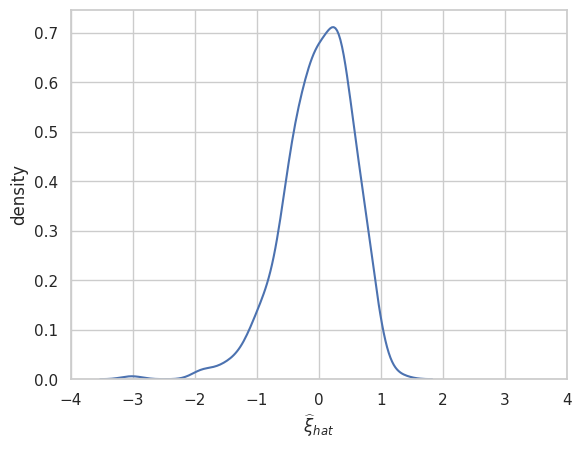

In [146]:
sns.kdeplot(data['xi_hat'])
plt.xlabel(r'$\widehat \xi_{hat}$')
plt.ylabel('density')
plt.xlim(-4,+4)
plt.show()

## 7. COMPUTING A COUNTERFACTUAL EQUILIBRIUM

Suppose we want to find out how much Häagen-Dazs's profit would change if sold ice cream as good as Ben \& Jerry's (i.e., if the Häagen-Dazs coefficient was zero) assuming its marginal cost did not change.

First, we calculate the variable profit using the data.

In [148]:
pi_0 = ((data[data['Häagen-Dazs'] == 1]['sales'])*(data[data['Häagen-Dazs'] == 1]['price'] - data[data['Häagen-Dazs'] == 1]['c_hat'])).sum()
print('Häagen-Dazs\'s variable profit in the current equilibrium are $',pi_0.astype(int),'.')

Häagen-Dazs's variable profit in the current equilibrium are $ 3908 .


To find the new prices (and market shares) we need to find the new Nash equilibrium. That is, we need to find the set of prices that satisfy firms' FOCs.

In [ ]:
def foc(P,C,params):
    const,alpha,beta = params
    return alpha*s(P,params)*(1-s(P,params))*(P-C) + s(P,params)


To calculate `foc` we have to write functions that calculate market shares (`s`) which in turn depend on the mean utilities (`V`).



In [ ]:
def s(P,params):
    return np.exp(V(P,params))/(1 + np.exp(V(P,params)))

def V(P,params):
    const,alpha,beta = params
    return const + alpha*np.array(P) + beta*np.array([0,1])

Let's use our 2SLS estimates (except that we set the Häagen-Dazs coefficient to zero) and the marginal costs that we have calculated to calculate the new prices `P_new`.

In [ ]:
res = optimize.root(foc,[0,0],args=(C_hat,[const,alpha,0]))
print('Root found?',res.success)
P_new = res.x
s_new = s(P_new,[const,alpha,0])
print('The new Häagen-Dazs unit price is $',round(P_new[0],2),', and the new Ben & Jerry\'s unit price is $',round(P_new[1],2),'.')
print('The new Häagen-Dazs market share is',round(100*s_new[0],0),'%. Ben & Jerry\'s market share is',100*round(s_new[1],2),'%.')

Root found? True
The new Häagen-Dazs unit price is $ 2.53 , and the new Ben & Jerry's unit price is $ 2.49 .
The new Häagen-Dazs market share is 13.0 %. Ben & Jerry's market share is 13.0 %.


We find that the prices and market shares of Häagen-Dazs and Ben & Jerry's are roughly the same. Can you explain why?

Next, we calculate Häagen-Dazs new (variable) profit.

In [ ]:
pi_1 = (data[data['Häagen-Dazs'] == 1]['county size']*s_new[0]*(P_new[0] - C_hat[0])).sum()
print('Häagen-Dazs\'s variable profit in the new equilibrium are $',pi_1.astype(int),'.')
print('Häagen-Dazs would benefit by $',(pi_1-pi_0).astype(int),' if its ice cream was as good as Ben \& Jerry\'s.')


Häagen-Dazs's variable profit in the new equilibrium are $ 7321 .
Häagen-Dazs would benefit by $ 4969  if its ice cream was as good as Ben \& Jerry's.
